In [1]:
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
import os
import scipy.sparse as sparse
import anndata

import seaborn as sns

sc.logging.print_header()
# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3 # errors (0), warnings (1), info (2), hints (3)

sns.set_style("white")

np.random.seed(0)

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.0 pandas==1.3.5 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.4


In [2]:
section_id = '151675'
adata = sc.read_visium(path='Data/151675', count_file=section_id + '_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading Data\151675\151675_filtered_feature_bc_matrix.h5
 (0:00:00)


In [3]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000)
hvg_filter = adata.var['highly_variable']
sc.pp.normalize_total(adata, inplace=True)
adata_all_genes = adata.copy()
adata = adata[:, hvg_filter]
display(adata)

filtered out 17476 genes that are detected in less than 10 cells
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)


View of AnnData object with n_obs × n_vars = 3592 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

### We determine that in 10 $\times$ dataset, all spot to its neighbors is the same distance



Median distance to closest cell = 138.00362314084367

Edge weights (distance between cells): median = 138.00362314084367, mode = 137.00364958642524


Edge weights (weights between cells): median = 0.16670164151558636, mode = 0.16612198117491883



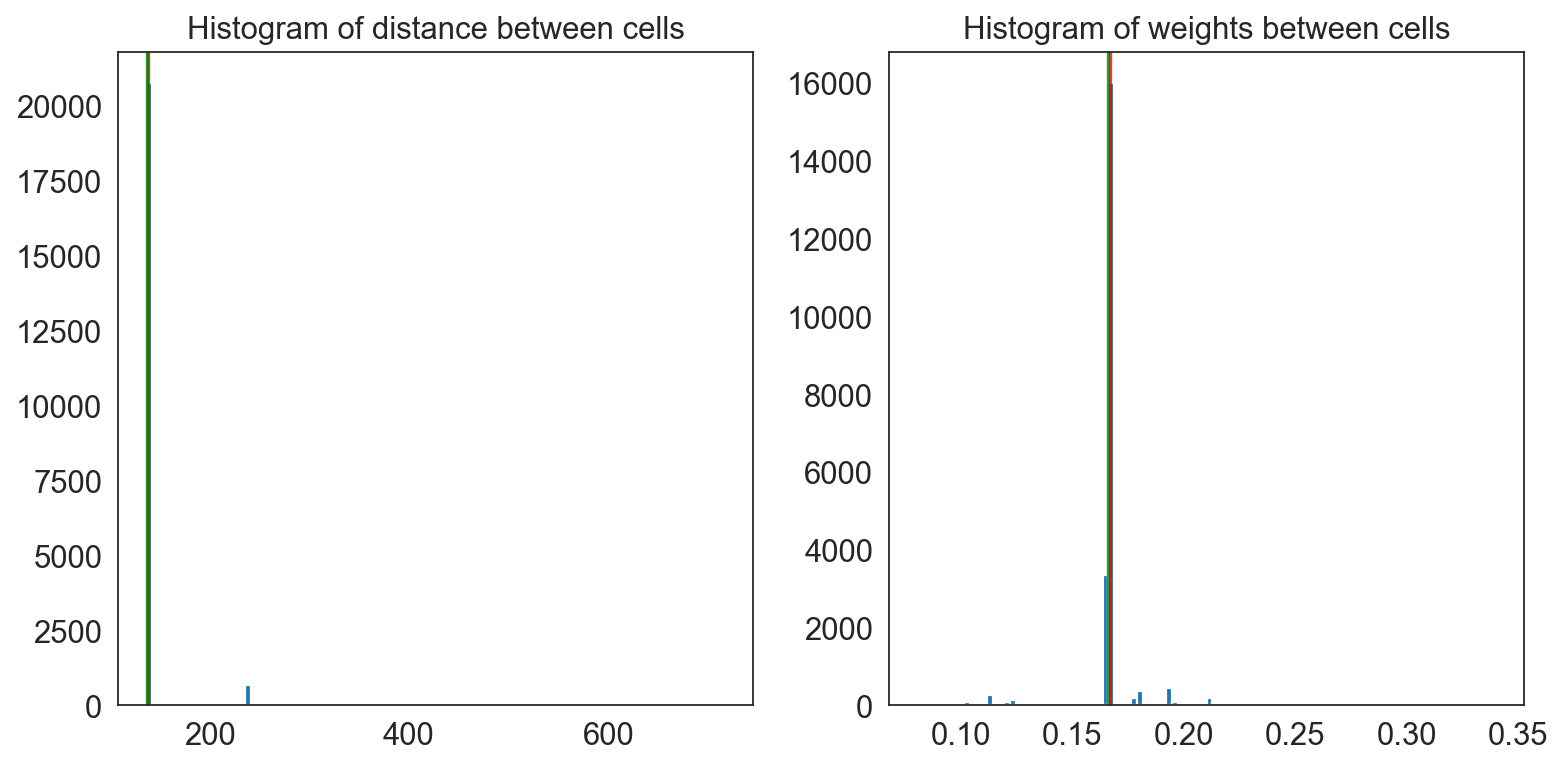

In [4]:

from sklearn.neighbors import NearestNeighbors
from utils import plot_edge_histogram, generate_spatial_weights_fixed_nbrs

num_neighbours = 6
nbrs = NearestNeighbors(algorithm='ball_tree').fit(adata.obsm['spatial'])
distances, indices = nbrs.kneighbors(n_neighbors=num_neighbours)
median_cell_distance = np.median(distances)
print(f"\nMedian distance to closest cell = {median_cell_distance}")

# 将细胞间距离以直方图的形式给出
weights_graph, distance_graph = generate_spatial_weights_fixed_nbrs(adata.obsm['spatial'], num_neighbours=num_neighbours, decay_type='reciprocal', nbr_object=nbrs, verbose=False)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot_edge_histogram(distance_graph, ax[0], title='distance between cells')
plot_edge_histogram(weights_graph, ax[1], title='weights between cells')
fig.tight_layout()

#### Inspired by BANKSY, we use neighbor spots' expression to enhance current spot:
$$
current_count = [count; \alpha * Neigh_Count]
$$
it means, if expression count file $X \in R^{n * m}$, after enhance, it will be $\hat{X} \in R^{n * 2m}$

In [5]:
from utils import weighted_concatenate, zscore, matrix_to_adata

gene_list = adata.var.index

nbrhood_contribution = 0.2

neighbour_agg_matrix = weights_graph @ adata.X

if sparse.issparse(adata.X):
    concatenated = sparse.hstack((adata.X, neighbour_agg_matrix), )
else:
    concatenated = np.concatenate((adata.X, neighbour_agg_matrix), axis=1,)

matrix = weighted_concatenate(zscore(adata.X, axis=0), zscore(neighbour_agg_matrix, axis=0), nbrhood_contribution)


if sparse.issparse(matrix):
    st_dev_pergene = matrix.toarray().std(axis=0)
else:
    st_dev_pergene = matrix.std(axis=0)

enhanced_data = matrix_to_adata(matrix, adata)
display(enhanced_data)

num_nbrs: 3000


AnnData object with n_obs × n_vars = 3592 × 6000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'is_nbr'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

In [6]:
enhanced_data.obs['Ground Truth'] = pd.read_csv(os.path.join('Data', section_id, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)

In [7]:
sc.pp.pca(enhanced_data, n_comps=100)
low_dim_x = enhanced_data.obsm['X_pca']

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:06)


#### for numpy module in python is relative slow, we recommend to use the matlab code file to run our network construction algorithm, and affinity graph learning.

In [26]:
# pd.DataFrame(low_dim_x).to_csv('data_for_matlab/' + section_id + '_exp_data.csv')
# pd.DataFrame(weights_graph).to_csv('data_for_matlab/' + section_id + '_adj.csv')

### After matlab file executed, the affinity graph will be generated, and we use leiden to partition it.

In [8]:
import igraph as ig
import leidenalg
from natsort import natsorted

learned_graph_from_matlab = pd.read_csv('matlab_rs/learned_151675.csv', header=None)
learned_graph_from_matlab = learned_graph_from_matlab.to_numpy()

sources, targets = learned_graph_from_matlab.nonzero()
ans_weight = learned_graph_from_matlab[sources, targets]
g = ig.Graph(directed=True)
g.add_vertices(learned_graph_from_matlab.shape[0])  # this adds adjacency.shape[0] vertices
g.add_edges(list(zip(sources, targets)))
g.es['weight'] = ans_weight

In [21]:
partition_type = leidenalg.RBConfigurationVertexPartition
partition_kwargs = {'weights': np.array(g.es['weight']).astype(np.float64), 'n_iterations': -1, 'seed': 42,
                    'resolution_parameter': 1.3}

part = leidenalg.find_partition(g, partition_type, **partition_kwargs)
# store output into adata.obs
groups = np.array(part.membership)
leiden_label = pd.Categorical(
    values=groups.astype('U'),
    categories=natsorted(map(str, np.unique(groups))),
)
print(leiden_label)
enhanced_data.obs['mnmst_pred'] = leiden_label
enhanced_data.obs["mnmst_pred"] = enhanced_data.obs["mnmst_pred"].astype('int')
enhanced_data.obs['mnmst_pred'] = enhanced_data.obs['mnmst_pred'].astype('category')

['5', '0', '1', '4', '2', ..., '3', '1', '1', '2', '1']
Length: 3592
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']


In [15]:
print(leiden_label)

['5', '0', '1', '4', '2', ..., '3', '1', '1', '2', '1']
Length: 3592
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']


In [22]:
def refine(sample_id, pred, dis, shape="hexagon"):
    refined_pred = []
    pred = pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df = pd.DataFrame(dis, index=sample_id, columns=sample_id)
    if shape == "hexagon":
        num_nbs = 6
    elif shape == "square":
        num_nbs = 4
    else:
        print("Shape not recongized, shape='hexagon' for Visium data, 'square' for ST data.")
    for i in range(len(sample_id)):
        index = sample_id[i]
        dis_tmp = dis_df.loc[index, :][dis_df.loc[index, :] > 0]
        nbs = dis_tmp[0: num_nbs + 1]
        nbs_pred = pred.loc[nbs.index, "pred"]
        self_pred = pred.loc[index, "pred"]
        v_c = nbs_pred.value_counts()
        if self_pred in nbs_pred:
            if (v_c.loc[self_pred] < num_nbs / 2) and (np.max(v_c) > num_nbs / 2):
                refined_pred.append(v_c.idxmax())
            else:
                refined_pred.append(self_pred)
        else:
            refined_pred.append(v_c.idxmax())
    return refined_pred

In [23]:
refined_pred = refine(sample_id=enhanced_data.obs.index.tolist(), pred=enhanced_data.obs["mnmst_pred"].tolist(), dis=weights_graph.A, shape="hexagon")
enhanced_data.obs["refined_pred"] = refined_pred
enhanced_data.obs["refined_pred"] = enhanced_data.obs["refined_pred"].astype('category')

In [24]:
obs_df = enhanced_data.obs.dropna()
raw_ari = adjusted_rand_score(obs_df['Ground Truth'], obs_df['mnmst_pred'])
refine_ari = adjusted_rand_score(obs_df['Ground Truth'], obs_df['refined_pred'])

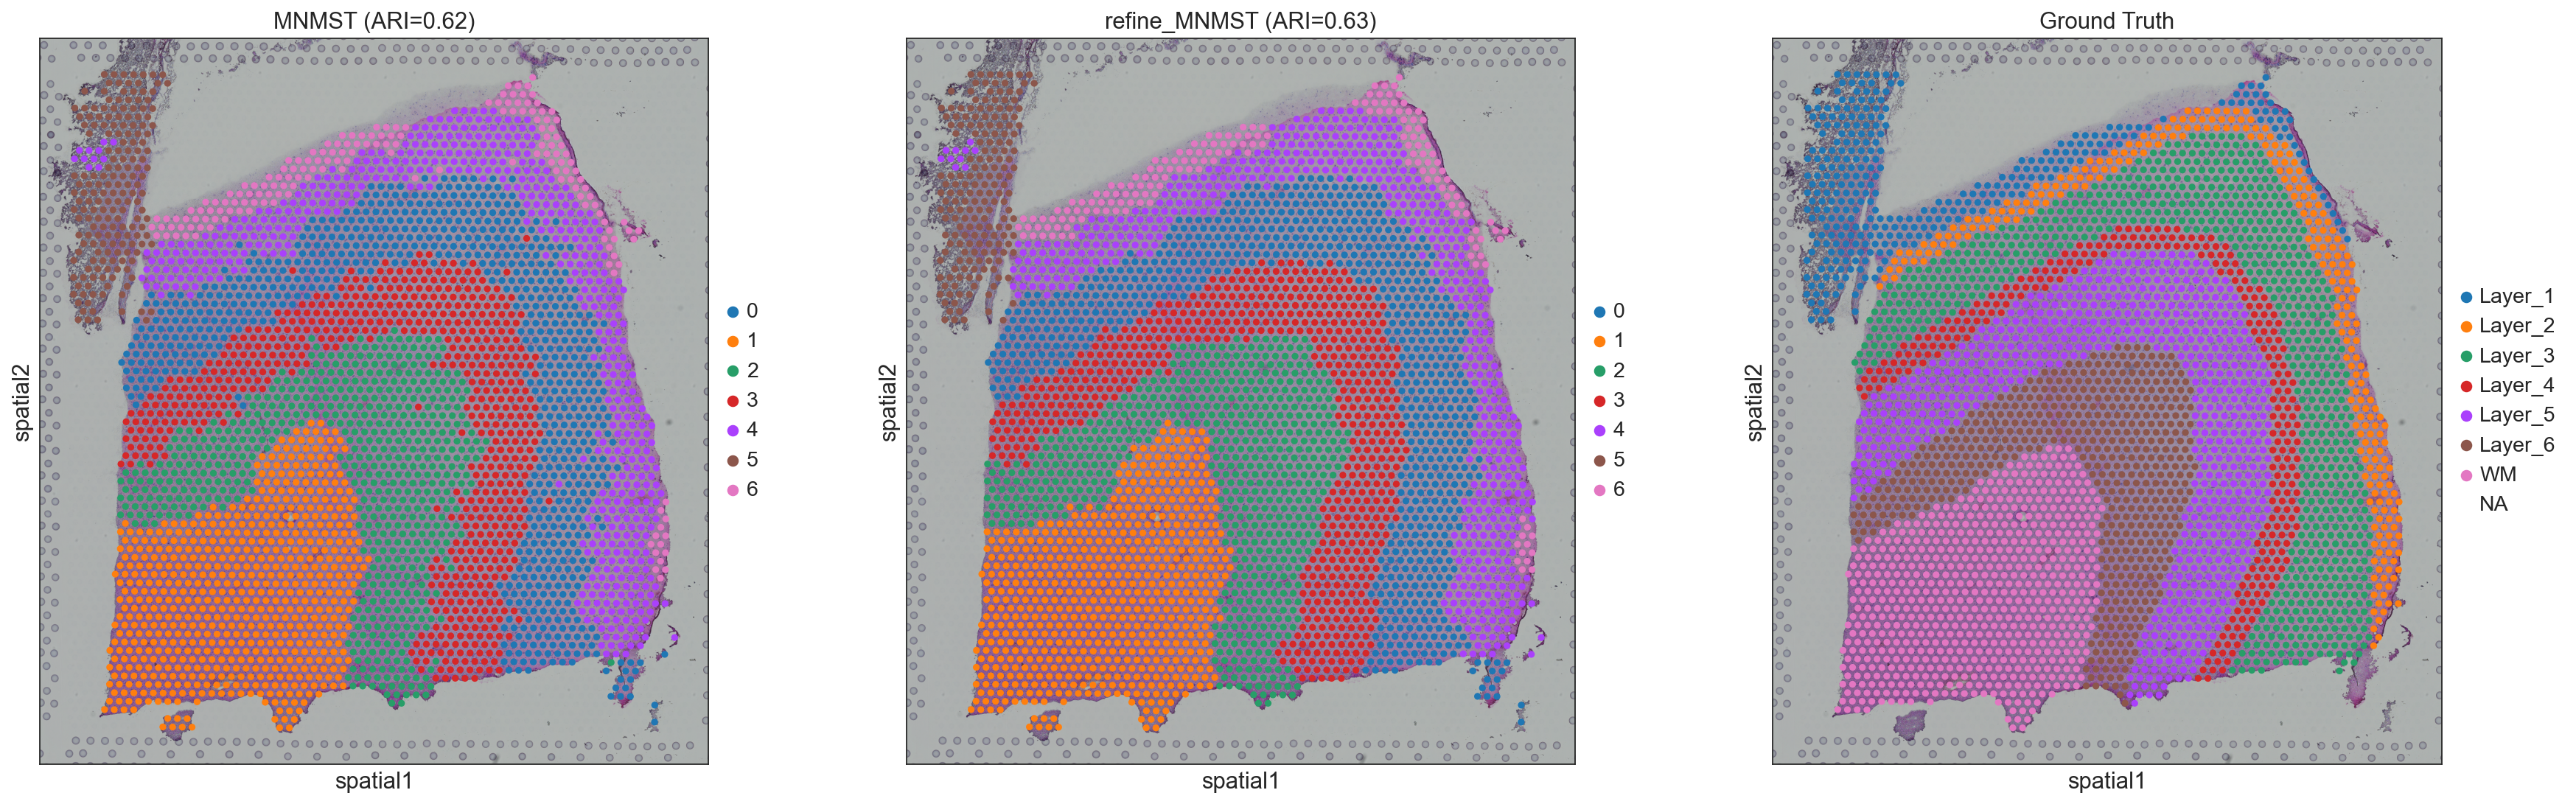

In [25]:
sc.pl.spatial(enhanced_data, color=['mnmst_pred', 'refined_pred', 'Ground Truth'], title=['MNMST (ARI=%.2f)'% raw_ari, 'refine_MNMST (ARI=%.2f)'% refine_ari, 'Ground Truth'])